In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import math
import seaborn as sn
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from sklearn.calibration import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')
test = pd.read_csv('test.csv')

In [4]:
# Separate features and labels
X_train = train.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
y_train = train[['label_1', 'label_2', 'label_3', 'label_4']]
X_val = valid.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
y_val = valid[['label_1', 'label_2', 'label_3', 'label_4']]
X_test = test.drop(['ID'], axis=1)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [6]:
pca = PCA(n_components=0.95, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [7]:
from sklearn.metrics import classification_report

def get_score(model, X_train, y_train, X_val, y_val, verbose = False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    if verbose:
        print(classification_report(y_val, y_pred))

    return accuracy_score(y_val, y_pred) * 100

Text(0.5, 0, 'Speaker Gender')

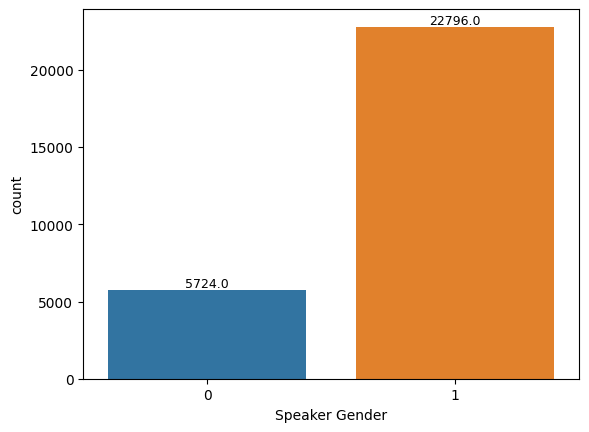

In [8]:
ax = sn.countplot(x=y_train['label_3'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, color='black')
    
plt.xlabel('Speaker Gender')

In [9]:
from xgboost import XGBClassifier

get_score(
    XGBClassifier(tree_method='gpu_hist', gpu_id= 0),
    X_train_pca, y_train['label_3'],
    X_val_pca, y_val['label_3']
)

61.46666666666667

In [62]:
from xgboost import XGBClassifier

cross_val_score(XGBClassifier(tree_method='gpu_hist', gpu_id= 0), X_train_pca, y_train['label_3'], cv=5).mean() * 100

96.52875175315569

In [63]:
cross_val_score(SVC(), X_train_pca, y_train['label_3'], cv=5).mean() * 100

97.92776998597475

In [17]:
# param_dist = { "learning_rate": np.linspace(0,0.2,5),
#                "max_depth": randint(3, 10)}
               
# #Instantiate RandomSearchCV object
# rscv = RandomizedSearchCV(CatBoostClassifier(task_type="GPU",
#                            devices='0:1'), param_dist, scoring='accuracy', cv =5)

# #Fit the model
# rscv.fit(X_train_pca, y_train['label_3'])

# print(rscv.best_params_)
# print(rscv.best_score_)

In [18]:
rscv.best_score_

0.9731065918653578

In [22]:
rscv

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f272173fd00>,
                   param_distributions={'learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f27cbc19c90>},
                   scoring='accuracy')

In [19]:
rscv.best_params_

{'learning_rate': 0.15000000000000002, 'max_depth': 7}

In [21]:
get_score(
    CatBoostClassifier(learning_rate=0.15, max_depth= 7, task_type="GPU", devices='0:1'),
    X_train_pca, y_train['label_3'],
    X_val_pca, y_val['label_3']
)

0:	learn: 0.5574961	total: 58.9ms	remaining: 58.8s
1:	learn: 0.4762259	total: 115ms	remaining: 57.3s
2:	learn: 0.4161778	total: 170ms	remaining: 56.3s
3:	learn: 0.3696248	total: 221ms	remaining: 54.9s
4:	learn: 0.3406048	total: 270ms	remaining: 53.8s
5:	learn: 0.3145706	total: 322ms	remaining: 53.4s
6:	learn: 0.2949188	total: 374ms	remaining: 53.1s
7:	learn: 0.2776858	total: 426ms	remaining: 52.8s
8:	learn: 0.2625859	total: 479ms	remaining: 52.7s
9:	learn: 0.2505882	total: 529ms	remaining: 52.3s
10:	learn: 0.2401332	total: 579ms	remaining: 52.1s
11:	learn: 0.2304531	total: 631ms	remaining: 52s
12:	learn: 0.2224458	total: 683ms	remaining: 51.8s
13:	learn: 0.2142321	total: 734ms	remaining: 51.7s
14:	learn: 0.2060885	total: 786ms	remaining: 51.6s
15:	learn: 0.1986965	total: 836ms	remaining: 51.4s
16:	learn: 0.1914166	total: 888ms	remaining: 51.3s
17:	learn: 0.1862202	total: 939ms	remaining: 51.2s
18:	learn: 0.1802645	total: 990ms	remaining: 51.1s
19:	learn: 0.1745200	total: 1.04s	remainin

63.46666666666667

In [35]:
get_score(
    SVC(class_weight='balanced', C=1000, gamma=0.001),
    X_train_pca, y_train['label_3'],
    X_val_pca, y_val['label_3']
)

81.06666666666666

In [10]:
cross_val_score(SVC(C=1000), X_train_pca, y_train['label_3'], cv=5).mean() * 100

98.24684431977559

In [65]:
cross_val_score(
    CatBoostClassifier(learning_rate=0.15, max_depth= 7, task_type="GPU", devices='0:1'), 
    X_train_pca, y_train['label_3'], cv=5).mean() * 100

0:	learn: 0.5600159	total: 53.7ms	remaining: 53.6s
1:	learn: 0.4700514	total: 108ms	remaining: 53.9s
2:	learn: 0.4069463	total: 160ms	remaining: 53.3s
3:	learn: 0.3669907	total: 209ms	remaining: 51.9s
4:	learn: 0.3354090	total: 255ms	remaining: 50.8s
5:	learn: 0.3099235	total: 302ms	remaining: 50s
6:	learn: 0.2893098	total: 348ms	remaining: 49.4s
7:	learn: 0.2721530	total: 394ms	remaining: 48.8s
8:	learn: 0.2595014	total: 440ms	remaining: 48.4s
9:	learn: 0.2450480	total: 488ms	remaining: 48.3s
10:	learn: 0.2324479	total: 534ms	remaining: 48s
11:	learn: 0.2226947	total: 580ms	remaining: 47.7s
12:	learn: 0.2142844	total: 625ms	remaining: 47.5s
13:	learn: 0.2057879	total: 671ms	remaining: 47.2s
14:	learn: 0.1983633	total: 717ms	remaining: 47.1s
15:	learn: 0.1906405	total: 762ms	remaining: 46.9s
16:	learn: 0.1842927	total: 808ms	remaining: 46.7s
17:	learn: 0.1776823	total: 854ms	remaining: 46.6s
18:	learn: 0.1723588	total: 899ms	remaining: 46.4s
19:	learn: 0.1670497	total: 944ms	remaining:

97.31065918653577

In [67]:
best_model_label_3 = SVC(C=1000)

In [6]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

halving_cv = HalvingGridSearchCV(SVC(), {
    'C': [1, 10,100,1000,1500,2000],
    'kernel': ['rbf'],
    'gamma': ['scale','auto', 0.1, 0.01, 0.001]
})
halving_cv.fit(X_train_scaled, y_train['label_3'])

print("Best Params", halving_cv.best_params_)
print("Best CV Score", halving_cv.best_score_)

Best Params {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best CV Score 0.9868817958611015
